In [69]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import zuko
import lampe.inference, lampe.utils
import matplotlib.pyplot as plt
import tqdm

In [70]:
N = 50000
mu=0
sigma = 0.01
tau = 0.25
rho = 1/2

Utils

In [71]:
def generate_data(N, mu):
    
    sample = mu + torch.distributions.Normal(0, 1).sample((N, 100 ))
    x_raw = torch.cat((sample.mean(dim=1, keepdim=True), sample.std(dim=1, keepdim=True)), dim=1)
    
    y_raw = x_raw + torch.distributions.Normal(0, 1).sample()
    
    return x_raw, y_raw
    

In [72]:
prior_over_mu = torch.distributions.Normal(torch.zeros(1), torch.ones(1)*25)

In [73]:
def simulator(N_train,N_test, prior):
    N = N_train + N_test
    theta = prior.sample((N, ))
    
    sample = torch.distributions.Normal(theta.unsqueeze(1), 1.0).sample((100, ))
    
    x_raw = torch.cat((sample.mean(dim=0, keepdim=True), sample.std(dim=0, keepdim=True)), dim=2).squeeze_()
    theta, theta_test = theta.split(N_train)
    x_raw, x_raw_test = x_raw.split(N_train)
    return theta, theta_test, x_raw, x_raw_test

In [74]:
x.mean(0)

tensor([-4.8828e-09,  5.3040e-07])

In [75]:
theta, theta_test, x_raw, x_test_raw = simulator(N, N//10, prior_over_mu)

x = (x_raw - x_raw.mean(0) ) / x_raw.std(0)
x_test = (x_test_raw - x_test_raw.mean(0) ) / x_test_raw.std(0)

In [76]:
dataset = lampe.data.JointDataset(theta, x)
dataset_test = lampe.data.JointDataset(theta_test, x_test)
_, y_raw = generate_data(N,5)
y = (y_raw - y_raw.mean(0) ) / y_raw.std(0)

def true_dgp(mus):
    """True Data Generating Process. Generates samples from N(mu, 2)

    Args:
        mus (torch.Tensor): mean

    Returns:
        res (torch.Tensor): tensor of means, std of the samples
    """
    res = torch.empty((mus.shape[0], 2))
    for i, mu in enumerate(mus):
        
        dist=  torch.distributions.Normal(mu, 2)
        sample = dist.sample((100, ))
        mean, var = torch.mean(sample).item(), torch.var(sample).item()
        x = mean, var
        res[i] = torch.tensor(x)
    return res

Simulation (line 1 & 2 of Algorithm 1)

def simulator(thetas: torch.Tensor):
    """Simulator, maps theta -> x = (mean, var)

    Args:
        thetas (torch.Tensor): Parameters

    Returns:
        torch.Tensor: Tensor of size (theta.size, 2) of (mean, var)
    """
    N = thetas.size()[0]
    x = torch.empty((N, 2))
    for i, theta in enumerate(thetas):
        dist = torch.distributions.Normal(theta, 1.0)
        samples = dist.sample((100,))
        means, var = torch.mean(samples), torch.var(samples)
        x[i][0], x[i][1] = means, var
    return x

def scale(quantity):
    '''
    Standardizes the quantity
    '''
    means, std = quantity.mean(axis=0), quantity.std(axis=0)
    quantity = quantity - means
    quantity = quantity/std
    return quantity
def get_stats(quantity):
    mean = quantity.mean(axis=0)
    std = quantity.std(axis=0)
    return mean, std

stats = {}
#Raw simulations
theta = prior_over_mu.sample((N, ))
stats["theta"] = get_stats(theta)
x_raw = simulator(theta)
stats["x"] = get_stats(x_raw)
#Standardized versions

x = scale(x_raw)
dataset = lampe.data.JointDataset(theta, x)


theta_test = scale(prior_over_mu.sample((N//10, )))
x_test = scale(simulator(theta_test))
dataset_test = lampe.data.JointDataset(theta_test, x_test)

'''Creates a 'true' dataset (theta*, x*) ~ p(theta, x)'''


thetas_star_raw = mu_dist.sample((N//10, ))
stats["thetas_star"] = get_stats(thetas_star_raw)
thetas_star = scale(thetas_star_raw)
y_star_raw = true_dgp(thetas_star)
stats["y_star"] = get_stats(y_star_raw)
y_star = scale(y_star_raw)
dataset_star = lampe.data.JointDataset(thetas_star.unsqueeze(1), y_star)

def noisy_simulator():
    """Simulator taking the error model into account

    Returns:
        tuple: x_noisy, theta_noisy, x_noisy_test_raw, theta_noisy_test
    """
    #Sample the parameters theta [mu]

    x_noisy_raw, theta_noisy = x_raw.clone(), theta.clone()
    x_noisy_test_raw, theta_noisy_test = x_test.clone(), theta_test.clone()

    for i, x in enumerate(x_noisy_raw):
        spike_dist = torch.distributions.Normal(x, sigma)
        slab_dist = torch.distributions.Cauchy(x, tau)
        spike = (1 - rho) *spike_dist.sample()
        slab = rho * slab_dist.sample()
        x_noisy_raw[i] += spike + slab
    for i, x in enumerate(x_noisy_test_raw):
        spike_dist = torch.distributions.Normal(x, torch.Tensor([sigma]))
        slab_dist = torch.distributions.Cauchy(x, torch.Tensor([tau]))
        spike = ((1 - rho) *spike_dist.sample((1, )))[0]
        slab = (rho * slab_dist.sample((1, )))[0]
        x_noisy_test_raw[i] += spike + slab
    x_noisy = scale(x_noisy_raw)
    return x_noisy, theta_noisy, x_noisy_test_raw, theta_noisy_test

x_noisy, thetas_noisy, x_test_noisy, thetas_test_noisy = noisy_simulator()

dataset_noisy = lampe.data.JointDataset(thetas_noisy, x_noisy)

In [77]:
def train_NPE(flow, data, loss,theta_test, x_test, learning_rate=5*10e-4, max_epochs=50,batch_size=256,patience=5):
    """Trains a NPE.

    Args:
        flow (lampe.inference.NPE): A instanciated flow
        data (lampe.data.JointDataset): dataset (theta, x)
        loss (callable): a loss function
        theta_test (torch.Tensor): test batch
        x_test (torch.Tensor): test batch
        learning_rate (float, optional): Defaults to 5*10e-4.
        max_epochs (int, optional): Defaults to 50.
        batch_size (int, optional): Defaults to 256.
        patience (int, optional): Defaults to 5.

    Returns:
        lampe.inference.NPE: the trained NPE
    """
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    step = lampe.utils.GDStep(optimizer)
    #Creates the loader
    loader = lampe.data.DataLoader(data, batch_size)
    #For early stopping
    with torch.no_grad():
        min_loss = loss(theta_test,x_test)
    min_loss_list = [min_loss]
    
    flow.train()
    batch_norm_x = torch.nn.BatchNorm1d(x_test.shape[1])
    batch_norm_theta = torch.nn.BatchNorm1d(theta_test.shape[1])
    for epoch in tqdm.tqdm(range(max_epochs)):
        
        for theta_batch_raw, x_batch_raw in loader:
            theta_batch = batch_norm_theta(theta_batch_raw)
            x_batch = batch_norm_x(x_batch_raw)
            losses = loss(theta_batch, x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            batch_norm_theta(theta_batch_raw)
            batch_norm_x(x_batch_raw)
        
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(theta_test, x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f" Early stop at epoch {epoch}")
                break
    flow.eval()
    return flow
    

In [78]:
def train_unconditional(flow, x, x_test, loss, learning_rate=1e-2,max_epochs=50, batch_size=256, patience=5):
    """Train an unconditional flow

    Args:
        flow (zuko.flow): A instanciated flow
        x (torch.Tensor): 
        x_test (torch.Tensor): test batch
        loss (callable): a loss function
        learning_rate (float, optional): Defaults to 1e-3.
        max_epochs (int, optional): Defaults to 50.
        batch_size (int, optional): Defaults to 256.
        patience (int, optional): Defaults to 5.

    Returns:
        zuko.flow: the trained flow
    """
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    
    #Creates the loader
    loader = torch.utils.data.DataLoader(x, batch_size)
    min_loss_list = []
    #Early stopping
    with torch.no_grad():
        min_loss = -loss(x_test)
    min_loss_list = [min_loss]
    
    flow.train()
    for epoch in tqdm.tqdm(range(max_epochs)):
        
        for x_batch in loader:
                
            losses = loss(x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f"Early stop at epoch {epoch}")
                break
    return flow

Train NPE q(theta|x) on the simulated dataset {(thetai, xi)}, i=1, ... N
Uses a neural spline flow defining the transform on the interval [-5, 5] using 10  spline segments and 5 coupling layers. The base of the flow is a standard Gaussian distribution. 

In [79]:

def build_nsf(features, context):
    """Callable to instanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)
q_NPE = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss_NPE = lampe.inference.NPELoss(q_NPE)
q_NPE = train_NPE(q_NPE, dataset, loss_NPE, theta_test, x_test)
'''
q_NPE_noisy = lampe.inference.NPE(theta_dim=1,x_dim=2,build=build_nsf)
loss_NPE_noisy = lampe.inference.NPELoss(q_NPE_noisy)
q_NPE_noisy = train_NPE(q_NPE_noisy, dataset_noisy, loss_NPE_noisy, thetas_test_noisy,x_test_noisy)
'''

  8%|▊         | 4/50 [00:26<05:08,  6.70s/it]

 Early stop at epoch 4


NameError: name 'dataset_noisy' is not defined

### Sampling theta here as in the 'classic' NPE framework (i.e. assuming no error)

In [82]:
thetas_NPE = q_NPE.sample(x)

Train q(x) on {xi} i=1, ... N (so first gen the x)
For q(x) uses of a block neural autoregressive flow, single hidden layer of size 8D, x in R^d

In [83]:
q_x_NF = zuko.flows.NAF(features = 2, context=0, hidden_features=[8]*2,transforms=1)
loss_q_x = lambda x: -q_x_NF().log_prob(x).mean()
q_x_NF = train_unconditional(q_x_NF, x, x_test, loss_q_x)

  8%|▊         | 4/50 [00:09<01:46,  2.32s/it]

Early stop at epoch 4


Sample x~m from p(x | y0) % p(y0 \ x) q(x), m = 1, ... M using MCMC

Spike and slab

In [84]:
M = 100000
warm_up_steps = 20000
traj_length = 1
target_acceptance_prob = 0.95

In [85]:
class MHQTransition(lampe.inference.MetropolisHastings):
    def q(self, x:torch.Tensor):
        return q_x_NF()

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Suppose we observe y0

In [87]:
y0 = y[0]
y0

tensor([7.0964, 3.0077])

In [88]:
def p_y_given_x(x):
    z = torch.distributions.Bernoulli(rho).sample(x.shape)
    res = 1
    for j,x_j in enumerate(x):
        zj=z[j]
        if not zj:
            dist=  torch.distributions.Normal(x_j, sigma)
        else:
            dist = torch.distributions.Cauchy(x_j, tau)
        res *= dist.log_prob(y0).exp().sum()
    return res

def f(x):
    qx = q_x_NF().log_prob(x).exp()
    pyx = p_y_given_x(x)
    return qx*pyx           
            

In [89]:
sampler = lampe.inference.MetropolisHastings(q_x_NF().sample(),f=f)
with torch.no_grad():
    xm_samples = [s for s in tqdm.tqdm(sampler(M+warm_up_steps,burn=warm_up_steps))]
    xm_samples = torch.stack(xm_samples)

100000it [04:27, 373.38it/s]


In [90]:
import sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
def compare(flow,x,file):
    class1 = file
    post = flow.flow(x).sample()
    #post = scale(post)
    post_array = post.detach().numpy()
    class0 = post_array
    class0_labels = np.zeros(len(class0))
    class1_labels = np.ones(len(class1))
    data = np.concatenate((class0,class1), axis=0)
    labels = np.concatenate((class0_labels, class1_labels), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(data,labels)

    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test,y_pred)
    return acc
    

In [91]:
file = np.load("/home/tux/rnpe/robust_samples_paper.npy", allow_pickle=True)
compare(q_NPE,xm_samples,file)

0.9644

In [105]:
y0 = y0.to(device)
y0.device

device(type='cuda', index=0)

In [112]:
# Define the log-posterior distribution
D = x.shape[1]
def log_posterior(x, y):
    z = torch.distributions.Bernoulli(rho).sample(x.shape)
    log_prob = 0
    for j, x_j in enumerate(x):
        z_j = z[j]
        if not z_j:
            dist = torch.distributions.Normal(x_j, 0.01)
        else:
            dist = torch.distributions.Cauchy(x_j, 0.25)
        log_prob += dist.log_prob(y).sum()
    return log_prob

# Define the proposal distribution
def proposal(x):
    return torch.distributions.Normal(x, 0.1).sample()

# Set the initial state and number of iterations
x_init = torch.zeros(D)
n_iter = M+warm_up_steps

# Run the Metropolis-Hastings algorithm
x_samples = []
x_current = x_init.clone()
for i in tqdm.tqdm(range(n_iter)):
    # Propose a new state
    x_proposal = proposal(x_current)
    
    # Compute the acceptance probability
    log_prob_current = log_posterior(x_current, y0)
    log_prob_proposal = log_posterior(x_proposal, y0)
    log_prob_accept = log_prob_proposal - log_prob_current
    
    # Accept or reject the proposal
    if log_prob_accept > torch.log(torch.rand(1)):
        x_current = x_proposal
    x_samples.append(x_current.clone())

# Convert the samples to a tensor
x_samples = x_samples[warm_up_steps:len(x_samples)]
x_samples = torch.stack(x_samples)


  0%|          | 0/120000 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [93]:
compare(q_NPE,x_samples,file)

0.9999272727272728

In [94]:
file_xm = np.load("/home/tux/rnpe/denoise_xm_paper.npy")
xm_tensor = torch.Tensor(file_xm)
compare(q_NPE, xm_tensor, file)

0.9114181818181818

In [95]:
file_NPE = np.load("/home/tux/rnpe/thetas_NPE.npy")
compare(q_NPE, x, file_NPE) # q(theta | x)

0.50132

In [96]:
def compare_xm(my_xm, xm_paper):
    class1 = xm_paper
    class0 = my_xm.detach().numpy()
    class0_labels = np.zeros(len(class0))
    class1_labels = np.ones(len(class1))
    data = np.concatenate((class0,class1), axis=0)
    labels = np.concatenate((class0_labels, class1_labels), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(data,labels)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test,y_pred)
    return acc

compare_xm(xm_samples,file_xm)

0.93654

Sample theta ~q(theta | xm), m = 1, ..., M

In [97]:
with torch.no_grad():
    thetasm = q_NPE.sample(xm_samples)

In [98]:
from lampe.diagnostics import expected_coverage_mc, expected_coverage_ni
from lampe.plots import nice_rc, coverage_plot
npe_levels, npe_coverages = expected_coverage_mc(q_NPE.flow, dataset_star)
nnpe_levels, nnpe_coverages = expected_coverage_mc(q_NPE_noisy.flow, dataset_star)

fig = coverage_plot(npe_levels, npe_coverages, legend='NPE')
fig = coverage_plot(nnpe_levels, nnpe_coverages, legend='NNPE')

NameError: name 'dataset_star' is not defined

In [ ]:
def compute_log_prob(flow, thetas, x):
    res = []
    for i, xi in enumerate(x):
        log_prob = flow.flow(xi).log_prob(thetas)
        res.append(log_prob.detach().item())
    return res

In [ ]:
log_probs_RNPE = compute_log_prob(q_NPE, thetas_star, xm_samples)
log_probs_NPE = compute_log_prob(q_NPE, thetas_star, x)
log_probs_NNPE = compute_log_prob(q_NPE_noisy, thetas_star, x_noisy)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5002 and 3x64)

AttributeError: 'Axes' object has no attribute 'set_ylabels'

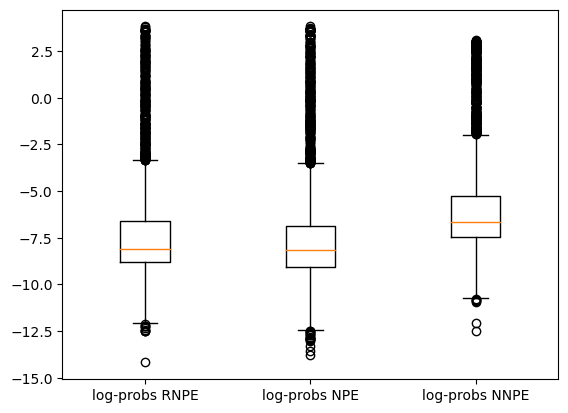

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([log_probs_RNPE, log_probs_NPE, log_probs_NNPE])


Il faut aussi faire les 2 autres simu cad NPE (comme avant) et en mettant directement le modele d'erreur dans le simu